# <center>Image annotation<br /> Workshop</center>

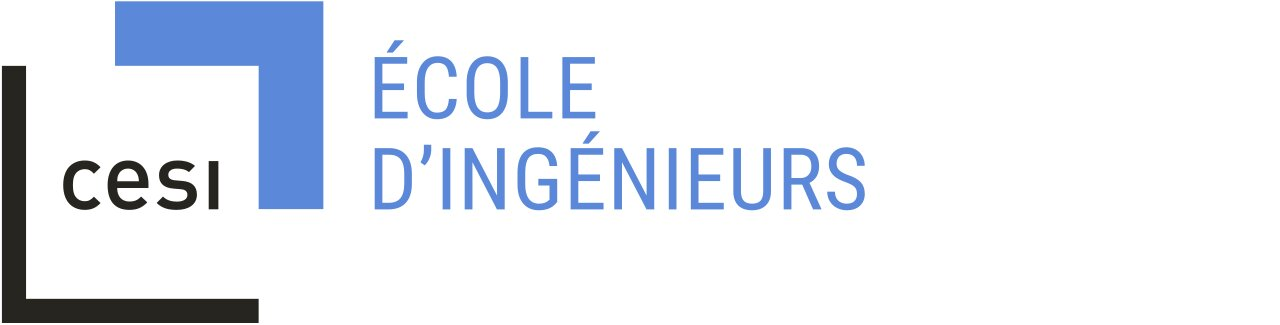
Concepteur : Nassim HADDAM
</div>

The aim of this workshop is to give you the skills you need to carry out the [image annotation] workshop (https://fr.wikipedia.org/wiki/Annotation_automatique_d%27images) (or image subtitling). In this workshop, you'll be using CNNs (to create attributes useful for annotation) and RNNs (to do the actual annotation). You'll also need to do **a lot** of pre-processing. This workshop will focus on this part of the process, and will give you an idea of the network architecture that will be used for annotation. We'll start by importing the libraries we're interested in.


You must, therefore, re-execute the cells corresponding to the data preparation of the previous workshop, going from the loading of the data to the preprocessing of the images and the annotations.
<br><br>
<b>Imports</b>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

<b>Loading the data</b>.

In [2]:
# Annotation file path

annotation_folder = "/CESI/Datasets/COCO/annotations"
annotation_file = annotation_folder +"/captions_train2014.json"

# Path to the folder containing the images to annotate
image_folder = '/CESI/Datasets/COCO/train2014/'
PATH = image_folder

# Reading the annotation file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Group all annotations with the same ID
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # mark the start and end of each annotation
    caption = f"<start> {val['caption']} <end>" 
    # The identifier of an image is part of its access path
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Add the caption associated with image_path
    image_path_to_caption[image_path].append(caption)
    
# Take the first images only
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:2000]

# List of all annotations
train_captions = []
# List of all file names of duplicated images (number of annotations per image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Add caption_list to train_captionss
    train_captions.extend(caption_list)     #solution
    # Add duplicate image_path len(caption_list) times
    img_name_vector.extend([image_path] * len(caption_list))  #solution




In [3]:
# Download the pre-trained InceptionV3 model with classification from ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation of a variable that will be the input for the new image pre-processing model
new_input = image_model.input 
 # retrieve the last hidden layer containing the image in compact representation
hidden_layer = image_model.layers[-1].output 

# Model that computes a dense representation of images with InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer) 

# Defining the load_image function
def load_image(image_path):
    """
    The load_image function has as its input as the path of an image and as its output as a pair
    containing the processed image and its path.
    The load_image function performs the following processing:
        1. Load the file corresponding to the path image_path
        2. Decodes the image into RGB.
        3. Resize image to size (299, 299).
        4. Normalise the image pixels between -1 and 1.
    """
    img = tf.io.read_file(image_path) #A COMPLETER
    img = tf.image.decode_jpeg(img, channels=3) #A COMPLETER
    img = tf.image.resize(img, (299,299)) #A COMPLETER
    img =  tf.keras.applications.inception_v3.preprocess_input(img) #A COMPLETER
    return img, image_path

# Pre-process images
# Take image names
encode_train = sorted(set(img_name_vector))

# Creating of an instance of “tf.data.Dataset” based on image names 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Split data into batches after load_image pre-processing
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Browse the dataset batch by batch to pre-process InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

100%|██████████| 125/125 [09:54<00:00,  4.75s/it]


**Pre-processing of annotations**

In [4]:
# Find the maximum size   
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the 5000 most frequently used words in the vocabulary
top_k = 5000
#The Tokenizer class can be used to pre-process text for neural networks. 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Build a vocabulary based on the train_captions list
tokenizer.fit_on_texts(train_captions) #A COMPLETER

# Create the token used to fill in the annotations to equalise their length
tokenizer.word_index['<pad>'] =  0 #A COMPLETER
tokenizer.index_word[0] = '<pad>' #A COMPLETER

# Creation of vectors (list of integer tokens) from annotations (list of words)
train_seqs =  tokenizer.texts_to_sequences(train_captions) #A COMPLETER

# Fill each vector up to the maximum annotation length
cap_vector =tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')  #A COMPLETER

# Calculate the maximum length used to store attention weights 
# This will be used later for display during evaluation
max_length = calc_max_length(train_seqs)

# 1 Forming the training and test set :
You must then separate the dataset into two parts: a training set and a test set. The code that performs these operations is detailed in the next cell.

In [5]:
img_to_cap_vector = collections.defaultdict(list)
# Creation of a dictionary associating image paths (.npy file) with annotations
# Images are duplicated because there are several annotations per image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Creation of training and validation datasets using a random 80-20 split
""" 
# Take the keys (names of processed image files), *these will not be duplicated*
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys) #Shuffle the image keys to ensure random splitting

# Dividing indices into training and testing
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:] #A COMPLETER

"""
The training and test sets are in the form of
lists containing mappings:(pre-processed image ---> annotation token(word))
"""

# Loop for building the training set
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Loop for building the test set
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    # Duplication des images en fonction du nombre d'annotations par image
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

# Optionally, print the lengths of the resulting lists
print("Number of training images:", len(img_name_train))
print("Number of training captions:", len(cap_train))
print("Number of validation images:", len(img_name_val))
print("Number of validation captions:", len(cap_val))

10005 10005
Number of training images: 8004
Number of training captions: 8004
Number of validation images: 2001
Number of validation captions: 2001


Creating a training dataset represented by a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) instance starting from the base dataset (the names of the files and annotations of the training set). The `tf.data.Dataset` class is used to represent large datasets and facilitates their preprocessing.

In [6]:
# Feel free to modify these parameters to suit your machine
BATCH_SIZE = 32         # batch size
BUFFER_SIZE = 500      # buffer size to mix data
embedding_dim = 256
units = 512             # Size of hidden layer in RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# The shape of the vector extracted from InceptionV3 is (64, 2048)
# The following two variables represent the shape of this vector
features_shape = 2048
attention_features_shape = 64

# Function to load numpy files from pre-processed images
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation of a “Tensor ”s dataset (used to represent large datasets)
# The dataset is created from “img_name_train” and “cap_train”.
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load numpy files (possibly in parallel)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

 
# Mix data and divide them into batches
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 2. The Model:

Regarding the model, the last convolutional layer of `InceptionV3` is of the form `(8, 8, 2048)`. This vector was reshaped to the form `(64, 2048)` when stored on disk. This vector is then passed through the CNN encoder (which consists of a single fully connected layer). The RNN will take care of predicting the next word in the annotation for this vector. [The image](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb) below shows an example of a very basic architecture of an annotation system using a CNN and an RNN.

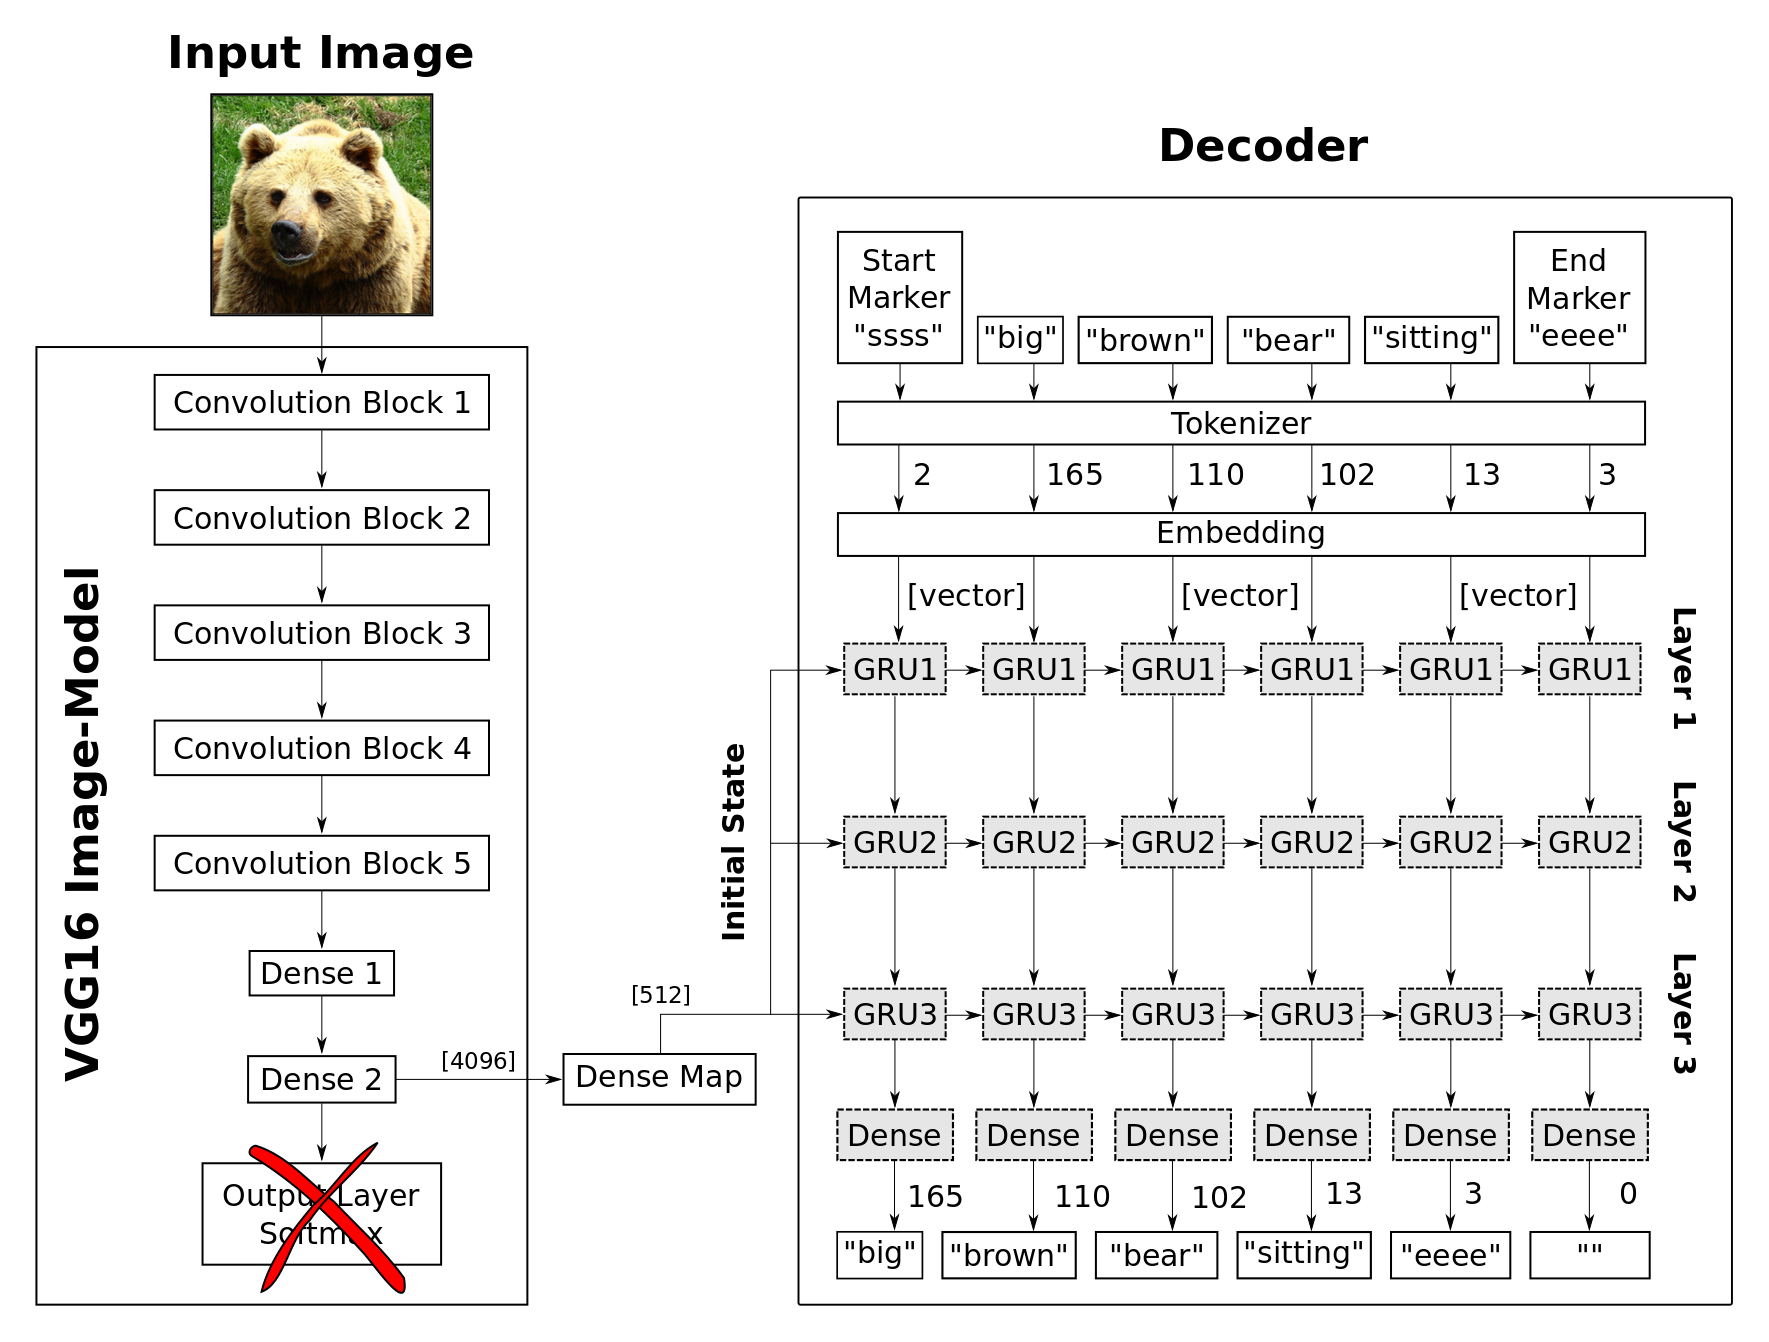

In this example, the captioning is done this way:
<ul>
<li>The image is passed through the CNN to have a compact representation of it. This representation is returned by the `Dense 2` layer of size 4096.</li>
<li>This representation is reduced by passing it to the dense layer `Dense Map` to be put as input as an initial hidden state to the RNN cells.</li>
<li>The RNN part is composed of <a href="https://openclassrooms.com">GRU</a> (Gated Recurent Unit). This part is made up of 3 layers. A layer representing in a fairly summary way a level of abstraction of the language. </li>
<li>The RNN has as input the annotation as well as the image in compact form, and returns for each column the word following the input word at the column level.</li>
<li>The annotations are represented as a list of words. This list cannot be used by the RNN, so it is passed to a module that replaces each word with an integer (or integer token), then by another module that projects each token into a vector whose elements are between -1 and 1.</li>
</ul>

Your annotation system will follow quite globally the same principle as shown in the image below, nevertheless it will contain essential differences distinguishing it from this example. The system will contain, in particular, an attention mechanism (explained in [article](https://arxiv.org/pdf/1502.03044.pdf) and in [the video](https://www.youtube.com/watch?v=uCSTpOLMC48&list=WL&index=257)) whose function is to lead the neural network to give greater importance in its predictions of the annotation to the most telling and relevant parts of the image.

**The CNN encoder:**

The CNN encoder produces an adequate representation of the image that it transmits to the RNN decoder to caption it. The CNN has as input the characteristics of the images already preprocessed by InceptionV3 and stored on disk.

A small note, in the CNN part of this neural network, the last convolutional layer is not flattened as in the case of the previous workshop on CNNs. Remember that the images resulting from the preprocessing by InceptionV3 were of the form 8x8x2048. These images were remodeled to have the size 64x2048. This means that this representation contains for each of the 64 positions of the preprocessed image the 2048 characteristics extracted by InveptoinV3. And therefore, the input of the CNN decoder is a batch where each element is made up of the 2048 characteristics of the 64 positions of the preprocessed image (which was originally 8x8). The dense layer that follows calculates a new representation of the image of size 64x256 or each position of the image therefore has 256 characteristics. The weights are the same for neurons of the same position that are on the same column in the preprocessed image (which are associated with the same characteristic of the image). This comes from the way the [dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) manages matrix operations in tensorflow.

The advantage of this representation compared to the flattened representation is to preserve spatial information at the level of the layers of the neural network. This will allow the attention mechanism of the RNN part to detect interesting positions at the level of the image and to inform the algorithm on which area it should focus the most importance to caption the image.

In [7]:
class CNN_Encoder(tf.keras.Model):
    # Since images are already pre-processed by InceptionV3 and represented in compact form
    # The CNN encoder will simply transmit these characteristics to a dense layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # The dense layer that projects the 2048 features to a space of dimension embedding_dim
        # The shape after the dense layer will be (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        # Apply dense layer to image features
        x = self.fc(x)
        # Apply ReLU activation
        x = tf.nn.relu(x)
        return x


**The attention mechanism:**

The attention mechanism is very similar to a [classic RNN](https://fr.wikipedia.org/wiki/R%C3%A9seau_de_neurones_r%C3%A9currents) cell, but with some differences. The attention part has as input the representation of the preprocessed image returned by the CNN as well as the current value of the hidden state of the GRU, and as output the **context vector** which reflects the most important characteristics of the image. An intermediate step to calculate this vector is to calculate the **attention weights** which represent the importance of each position of the image (there are 64) in the prediction of its annotation.

The representation of the image given as input is transformed at the beginning in the same way as for the CNN by passing it to a dense layer of size `units`. Similarly, the hidden state is also passed to a dense layer of size `units`. The new representation of the image is then added to the hidden state and passed to an activation function of type [`tanh`](https://fr.wikipedia.org/wiki/Tangente_hyperblique) as for classic RNN cells. At this level, we will have a representation of the data of size `64xunits` containing a mixture of information on the image and on the text of the annotation. A score is then associated with each of the positions by passing this representation to a dense layer. These scores are normalized with a softmax layer to produce the vector of **attention weights**.

Finally, each feature of the input image representation will be multiplied (weighted) by the attention vector. After which, we take the sum of each feature along the positions (the lines of the representation) to form the **context vector**.

Overall, we can say that the attention vector depends on scores that are learned from a spatial and textual representation of the image. This attention vector returns the relevance of each position and is used to calculate the context vector which will give us the importance of the image characteristics.

In [8]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # Dense layer applied to image features
        self.W1 = tf.keras.layers.Dense(units)
        # Dense layer applied to the decoder's hidden state
        self.W2 = tf.keras.layers.Dense(units)
        # Dense layer for calculating attention score
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features (output du CNN_encoder) forme == (batch_size, 64, embedding_dim)
        # hidden (état caché actuel) forme == (batch_size, hidden_size)

        # Ajouter une dimension temporelle à hidden pour pouvoir l'additionner aux features
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # Calculer la représentation cachée de l'attention
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # Calculer les scores d'attention
        score = self.V(attention_hidden_layer)

        # Calculer les poids d'attention en appliquant softmax
        attention_weights = tf.nn.softmax(score, axis=1)

        # Calculer le vecteur du contexte en pondérant les features par les poids d'attention
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


**The RNN decoder:**

The role of the RNN decoder is to use the preprocessed representation of the image to predict its caption word by word. This RNN has a single cell of type [GRU]( https://en.wikipedia.org/wiki/Gated_recurrent_unit ). The GRU has a hidden state that represents the memory of the last elements seen by it. The GRU updates its state before returning it, for this it uses certain memorization mechanisms that are quite sophisticated.

The decoder is structured as follows, at each call of the RNN, the current word as well as the representation of the image and the hidden state of the GRU are given as input to the RNN. Since words are represented by integers, we must pass them through a layer called [embedding layer]( https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding ) which will be responsible for calculating a vector representation of size `output_dim` starting from the number representing the word.

In addition to this, the attention mechanism provides a vector representing **the context** of the image, i.e. a vector that tells us about the dominant characteristics of the image. This vector is calculated by calling the attention mechanism by providing it as input the characteristics of the image encoded by the CNN as well as the hidden state of the GRU which summarizes the history of the words seen by the RNN so far.

Then, the current word and the context are concatenated to form the input vector of the GRU which in turn calculates the state in the next step. This state is passed through a dense layer of size `units` and then the output of this layer is passed to another dense layer of size `vocab_size` which returns the score associated with each word in the vocabulary in order to predict the next word.

In [9]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        # Couche embedding pour encoder les mots en vecteurs d'une dimension embedding_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # Cellule GRU qui prendra en entrée le vecteur concaténé (mot + contexte)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # Première couche dense après la GRU
        self.fc1 = tf.keras.layers.Dense(self.units)

        # Dernière couche dense pour obtenir les scores pour chaque mot du vocabulaire
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Mécanisme d'attention
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # Calcul du vecteur de contexte via le mécanisme d'attention
        context_vector, attention_weights = self.attention(features, hidden)

        # Passer le mot courant à la couche embedding
        x = self.embedding(x)

        # Concaténation du vecteur embedding et du vecteur de contexte
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passage du vecteur concaténé à la cellule GRU
        output, state = self.gru(x)

        # Passer la sortie de la GRU à la première couche dense
        y = self.fc1(output)

        # Remodeler la sortie avant la dernière couche dense
        y = tf.reshape(y, (-1, y.shape[2]))

        # Passer la sortie remodelée à la dernière couche dense pour obtenir les scores
        y = self.fc2(y)

        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


**Combine the encoder and decoder part:**

You need to complete the part of the code for creating the encoder and decoder.

In [10]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)

# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [11]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()

# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    # Calcul de la perte entre les étiquettes réelles et les prédictions
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # Ignorer les tokens de padding
    loss_ = loss_object(real, pred)  # Calcul de la perte entre les vraies étiquettes et les prédictions

    mask = tf.cast(mask, dtype=loss_.dtype)  # Convertir le masque en float
    loss_ *= mask  # Appliquer le masque à la perte pour ignorer les positions de padding

    return tf.reduce_mean(loss_)  # Retourner la moyenne des pertes pour ce batch


To keep track of your training and save it, you can use the [`tf.train.Checkpoint`](https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint) class.

In [12]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

Initializes the training start epoch in `start_epoch`. The `tf.train.Checkpoint` class allows you to continue training where you left off if it was previously interrupted.

In [13]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# 3 Training and testing:
You will then implement the `train_step` and `evaluate` functions:

- The `train_step` function represents a step in the training of the network. It is composed of the evaluation by the encoder of the vector pre-calculated by InceptionV3. The output of this step will be transmitted to the decoder which is responsible for predicting the annotation word by word. The loop to predict each word and calculate the associated loss must be implemented in this function.
- The `evaluate` function will be used to evaluate the performance of the network on the test set. It is therefore similar to the `train_step` function except that the loss function calculation part is absent because it is not a question of training the network.</li>

Finally, you must implement the part of the code that does the training and the test. Let us specify that the training is done here by batch of images.

# 3.1 Training
The function that allows to complete a training step on a batch of images is `train_step`. The function has as input a batch of preprocessed images as well as their annotations and returns the loss associated with this batch.

The hidden state of the RNN part is initialized as well as the starting word with the start token. The features of the image are then extracted by the encoder. After that, the batch is traversed word by word to predict the next word using the decoder. The decoder uses the hidden state, the features of the image as well as the previous word to predict the current word. The decoder updates the hidden state and returns it as well as the predictions of the batch. The loss is calculated from the predictions returned by the decoder and the annotations associated with the batch.

Finally, the global loss as well as the gradient are calculated and the network is updated.

In [14]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

The overall code containing the training loop is shown below. This loop iterates through the training dataset batch by batch and trains the networks with them.

c:\Users\Sharon\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['kernel', 'kernel', 'kernel', 'bias', 'kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 5 Batch 0 Loss 2.5069
Epoch 5 Batch 100 Loss 1.1288
Epoch 5 Batch 200 Loss 1.0496
Epoch 5 Loss 1.155796
Time taken for 1 epoch 1184.059475183487 sec

Epoch 6 Batch 0 Loss 0.9929
Epoch 6 Batch 100 Loss 1.0730
Epoch 6 Batch 200 Loss 0.8525
Epoch 6 Loss 0.929614
Time taken for 1 epoch 798.9478030204773 sec

Epoch 7 Batch 0 Loss 0.9239
Epoch 7 Batch 100 Loss 0.9090
Epoch 7 Batch 200 Loss 0.8159
Epoch 7 Loss 0.812776
Time taken for 1 epoch 760.2201232910156 sec

Epoch 8 Batch 0 Loss 0.7161
Epoch 8 Batch 100 Loss 0.7746
Epoch 8 Batch 200 Loss 0.7593
Epoch 8 Loss 0.734911
Time taken for 1 epoch 702.7603607177734 sec

Epoch 9 Batch 0 Loss 0.6349
Epoch 9 Batch 100 Loss 0.6770
Epoch 9 Batch 200 Loss 0.7055
Epoch 9 Loss 0.676959
Time taken for 1 epoch 728.8723230361938 sec

Epoch 10 Batch 0 Loss 0.6334
Epoch 10 Batch 100 Loss 0.5999
Epoch 10 Batch 200 Loss 0.5632
Epoch 10 Loss 0.627828
Time taken for 1 epoch 692.3809077739716 sec



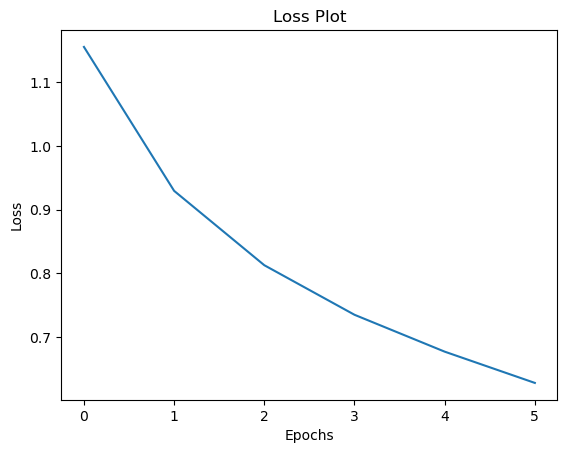

In [15]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # sauvegarde de la perte
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Affichage de la courbe d'entrainement
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# 3.2 Test
The function that allows to complete an evaluation step for the test is in the following cell.

In [16]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Displaying some examples on the result returned by the evaluation.

Real Caption: <start> there are people in the kitchen cooking <end>
Prediction Caption: two men sit together outside <end>


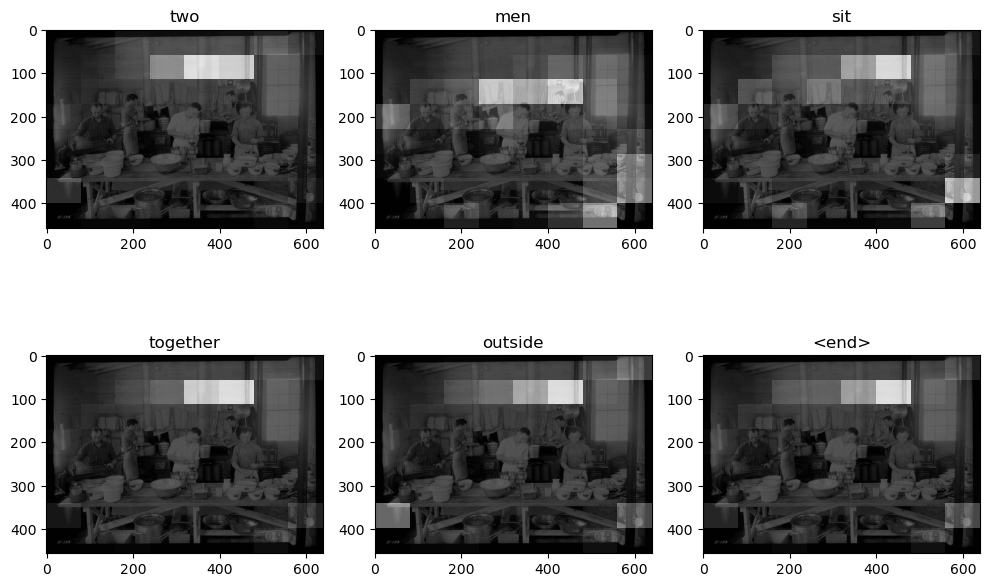

In [19]:
# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [20]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

# Tokenize the real caption (reference) and generated caption (candidate)
real_caption_tokens = word_tokenize(real_caption.lower())  # Tokenize and lowercase the real caption
result_tokens = word_tokenize(' '.join(result).lower())    # Tokenize and lowercase the generated caption

# Convert real caption into a list of references (BLEU expects a list of reference lists)
reference = [real_caption_tokens]  # A single reference for this example, but BLEU allows multiple references

# Calculate BLEU score (you can use different n-gram weights, default is BLEU-1 to BLEU-4)
bleu_score = sentence_bleu(reference, result_tokens)

# Output the BLEU score
print(f"BLEU score: {bleu_score:.4f}")


BLEU score: 0.0000


In [21]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

In [22]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

NameError: name 'test_features' is not defined

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Input
from tensorflow.keras.models import Model

# Input image (assume preprocessed)
image_input = Input(shape=(224, 224, 3))

# Pre-trained CNN (ResNet) for feature extraction
cnn_model = ResNet50(include_top=False, pooling='avg')
image_features = cnn_model(image_input)

# Input text (captions) with an embedding layer
vocab_size = 10000  # Example vocabulary size
max_caption_length = 20  # Maximum caption length
embedding_dim = 256
caption_input = Input(shape=(max_caption_length,))
word_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(caption_input)

# Option 1: Use image features as initial LSTM state
lstm_units = 512
lstm_layer = LSTM(lstm_units)
lstm_output = lstm_layer(word_embeddings, initial_state=[image_features])

# Option 2: Concatenate image features with word embeddings
# concatenated_input = Concatenate(axis=-1)([image_features, word_embeddings])
# lstm_output = lstm_layer(concatenated_input)

# Output layer (Softmax to predict the next word in the sequence)
output = Dense(vocab_size, activation='softmax')(lstm_output)

# Define the full model
model = Model(inputs=[image_input, caption_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 42s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 20, 256)   │  2,560,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 512)       │  1,574,912 │ embedding_1[0][0… │
│                     │                   │            │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10000)     │  5,130,000 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,852,624 (125.32 MB)

 Trainable params: 32,799,504 (125.12 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import json
from pycocotools.coco import COCO

class CocoDataset(Dataset):
    def __init__(self, transform, mode, coco_annotation_file, coco_image_folder, vocab, vocab_threshold=None):
        """
        Args:
            transform: Image transformations (resizing, normalization, etc.).
            mode: 'train', 'val', or 'test' for different dataset modes.
            coco_annotation_file: Path to COCO annotation file.
            coco_image_folder: Path to folder containing images.
            vocab: Vocabulary object (with word-to-index mapping).
        """
        self.transform = transform
        self.mode = mode
        self.coco = COCO(coco_annotation_file)
        self.coco_image_folder = coco_image_folder
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab

    def __getitem__(self, index):
        """
        Returns one image-caption pair or just an image (for testing/validation).
        """
        annotation_id = self.ids[index]
        annotation = self.coco.anns[annotation_id]
        image_id = annotation['image_id']
        caption = annotation['caption']
        path = self.coco.loadImgs(image_id)[0]['file_name']
        
        # Load image
        image = Image.open(os.path.join(self.coco_image_folder, path)).convert('RGB')
        image = self.transform(image)

        # Convert caption to word ids
        tokens = caption.lower().split()
        caption = []
        caption.append(self.vocab('<start>'))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab('<end>'))
        caption = torch.Tensor(caption).long()

        return image, caption

    def __len__(self):
        return len(self.ids)

def get_loader(transform, mode, batch_size, vocab_threshold, vocab_from_file, coco_annotation_file, coco_image_folder, shuffle=True):
    """Returns DataLoader for custom COCO dataset."""
    
    # Assume `vocab` is pre-built or loaded from file
    vocab = Vocabulary(vocab_threshold, vocab_from_file)

    dataset = CocoDataset(transform=transform,
                          mode=mode,
                          coco_annotation_file=coco_annotation_file,
                          coco_image_folder=coco_image_folder,
                          vocab=vocab)

    data_loader = DataLoader(dataset=dataset, 
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=0)
    return data_loader

class Vocabulary(object):
    def __init__(self, vocab_threshold, vocab_from_file):
        """Initialize the vocabulary."""
        if vocab_from_file:
            self.load_vocab()
        else:
            self.build_vocab(vocab_threshold)

    def build_vocab(self, threshold):
        """Build the vocabulary from the COCO dataset."""
        # This is a placeholder, implement vocab building logic.
        self.word2idx = {'<start>': 0, '<end>': 1, '<unk>': 2}
        self.idx2word = {0: '<start>', 1: '<end>', 2: '<unk>'}

    def load_vocab(self):
        """Load pre-built vocabulary from file."""
        # Add logic to load vocab from file if available
        self.word2idx = {'<start>': 0, '<end>': 1, '<unk>': 2}
        self.idx2word = {0: '<start>', 1: '<end>', 2: '<unk>'}

    def __call__(self, word):
        """Return the index of the word. If the word is not found, return <unk>."""
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


In [28]:
#blue 
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import sys
import os
from pycocotools.coco import COCO
#from data_loader import get_loader
from Model import EncoderCNN, DecoderRNN
import math


import torch.utils.data as data
from utils import get_batch_caps, get_hypothesis

import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 64            # batch size, change to 64
vocab_threshold = 3        # minimum word count threshold
vocab_from_file = True     # if True, load existing vocab file
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder
num_epochs = 10            # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss

log_train = 'training_log.txt'       # name of files with saved training loss and perplexity
log_val = 'validation_log.txt'
bleu = 'bleu.txt'

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)


# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
#params = list(decoder.parameters()) + list(encoder.parameters()) 
params = list(decoder.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr = 1e-4)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

ModuleNotFoundError: No module named 'Model'

In [ ]:
total_step_valid = math.ceil(len(valid_data_loader.dataset.caption_lengths) / valid_data_loader.batch_sampler.batch_size)
